In [41]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tlo import Date
from tlo.analysis.utils import (
    extract_results,
    summarize,
)
import matplotlib.dates as mdates

import geopandas as gpd

In [42]:
results_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

output_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

In [43]:
climate_sensitivity_analysis = False
main_text = True
parameter_uncertainty_analysis = False

if parameter_uncertainty_analysis:
    scenario_names = range(0,  200, 1)
    scenarios_of_interest = scenario_names
    suffix = "parameter_UA"
if main_text:
    scenario_names = [
        "Baseline",
        "Best Case",
        "Worst Case"
    ]
    suffix = "main_text"
    scenarios_of_interest = [0, 1, 2]


In [44]:

min_year = 2025
max_year = 2041
spacing_of_years = 1


Helper functions

In [45]:
target_year_sequence = range(min_year, max_year, spacing_of_years)

# Define the extraction functions (add these near your other helper functions)
def get_num_treatments_total_delayed(_df):
    """Count total number of delayed HSI events"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    print(_df)
    return pd.Series(len(_df), name="total")

def get_num_treatments_total_cancelled(_df):
    """Count total number of cancelled HSI events"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    return pd.Series(len(_df), name="total")

def get_num_treatments_total(_df):
    """Sum all treatment counts"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    total = {}
    for d in _df["hsi_event_key_to_counts"]:
        for k, v in d.items():
            total[k] = total.get(k, 0) + v
    print(sum(total.values()))
    return pd.Series(sum(total.values()), name="total")

def get_num_dalys_total(_df):
        """Return total number of DALYS (Stacked) by label (total by age-group within the TARGET_PERIOD)
        """
        return pd.Series(_df \
            .loc[_df.year.between(*[i.year for i in TARGET_PERIOD])] \
            .drop(columns=['date', 'sex', 'age_range', 'year']) \
            .sum().sum(), name="total")

def get_num_dalys_by_month(_df):
    """Sum all DALYs across all causes by month for the target year"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    # Sum across all disease columns (excluding non-disease columns)
    disease_columns = [col for col in _df.columns
                      if col not in ['age_range', 'month', 'sex', 'year', 'date']]

    # Group by month and sum
    monthly_dalys = _df.groupby('month')[disease_columns].sum().sum(axis=1)

    return monthly_dalys

def get_population_for_year(_df):
        """Returns the population in the year of interest"""
        _df["date"] = pd.to_datetime(_df["date"])

        # Filter the DataFrame based on the target period
        filtered_df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
        numeric_df = filtered_df.drop(columns=["female", "male"], errors="ignore")
        population_sum = numeric_df.sum(numeric_only=True)

        return population_sum



 Save results

# BEST/WORST CASE


In [46]:

results_folder_baseline = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/baseline_run_with_pop-2026-02-05T113912Z')


# Helper functions
def get_hsi_counts_by_facility_monthly(_df):
    """Get HSI counts by facility_id and month"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    if len(_df) == 0:
        return pd.Series(dtype=int)

    # Create keys like "2010-02_128" (month_facilityID)
    facility_month_totals = {}
    for _, row in _df.iterrows():
        month_key = row['date'].strftime('%Y-%m')
        counts_dict = row['counts']

        for key, value in counts_dict.items():
            if ':' in key:
                facility_id, _ = key.split(':', 1)
                facility_month_totals[facility_id] = facility_month_totals.get(facility_id, 0) + value

    return pd.Series(facility_month_totals)
def get_num_treatments_by_facility_delayed(_df):
    """Count number of delayed HSI events by facility"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="delayed_count")
    
    # Group by Facility_ID and count
    delayed_by_facility = _df.groupby('Facility_ID').size()
    delayed_by_facility.name = 'delayed_count'
    
    return delayed_by_facility


def get_num_treatments_by_facility_cancelled(_df):
    """Count number of cancelled HSI events by facility"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="cancelled_count")
    
    # Group by Facility_ID and count
    cancelled_by_facility = _df.groupby('Facility_ID').size()
    cancelled_by_facility.name = 'cancelled_count'
    
    return cancelled_by_facility

# Storage dictionaries
all_scenarios_appointment_delayed_mean = {}
all_scenarios_appointment_cancelled_mean = {}
all_scenarios_dalys_mean = {}
# Main loop
for draw in range(len(scenarios_of_interest)):
    print(draw)
    all_years_data_delayed_mean = {}
    all_years_data_cancelled_mean = {}
    all_years_dalys_mean = {}
    baseline_hsi_by_facility = {}
    
    for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Get baseline HSI by facility (sum across months to get yearly total per facility)
        hsi_by_facility = summarize(extract_results(
                    results_folder_baseline,
                    module='tlo.methods.healthsystem.summary',
                    key='hsi_event_counts_by_facility_monthly',
                    custom_generate_series=get_hsi_counts_by_facility_monthly,
                    do_scaling=False
                ), only_mean=True, collapse_columns=False)[draw]
        
        # Sum across months to get total by facility for the year
        hsi_by_facility.index = pd.Index([int(x) for x in hsi_by_facility.index], name='Facility_ID')

        baseline_hsi_by_facility[target_year] = hsi_by_facility

        if draw in [0]:
            all_years_data_delayed_mean[target_year] = pd.Series([0], name='mean')
            all_years_data_cancelled_mean[target_year] = pd.Series([0], name='mean')
        else:
            # Get delayed counts BY FACILITY
            num_delayed_by_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_delayed_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_delayed,  
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Get cancelled counts BY FACILITY
            num_cancelled_by_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_cancelled_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_cancelled,  
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]


            baseline_aligned, delayed_aligned = baseline_hsi_by_facility[target_year].align(num_delayed_by_facility, fill_value=0)
            delayed_proportions = delayed_aligned / baseline_aligned
            
            baseline_aligned, cancelled_aligned = baseline_hsi_by_facility[target_year].align(num_cancelled_by_facility, fill_value=0)
            cancelled_proportions = cancelled_aligned / baseline_aligned
            
            
            all_years_data_delayed_mean[target_year] = delayed_proportions
            all_years_data_cancelled_mean[target_year] = cancelled_proportions
            

    all_scenarios_appointment_delayed_mean[draw] = all_years_data_delayed_mean
    all_scenarios_appointment_cancelled_mean[draw] = all_years_data_cancelled_mean
    all_scenarios_dalys_mean[draw] = all_years_dalys_mean

0


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

1


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

2


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

In [30]:
# Now only those reporting disruptions
# Storage dictionaries
all_scenarios_appointment_delayed_mean_only_disruptions = {}
all_scenarios_appointment_cancelled_mean_only_disruptions = {}
all_scenarios_dalys_mean_only_disruptions = {}

# Main loop
for draw in range(len(scenarios_of_interest)):
    print(draw)
    all_years_data_delayed_mean_only_disruptions = {}
    all_years_data_cancelled_mean_only_disruptions = {}
    all_years_dalys_mean_only_disruptions = {}
    baseline_hsi_by_facility_only_disruptions = {}
    
    for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Get baseline HSI by facility (sum across months to get yearly total per facility)
        hsi_by_facility = summarize(extract_results(
                    results_folder_baseline,
                    module='tlo.methods.healthsystem.summary',
                    key='hsi_event_counts_by_facility_monthly',
                    custom_generate_series=get_hsi_counts_by_facility_monthly,
                    do_scaling=False
                ), only_mean=True, collapse_columns=False)[draw]
        
        # Sum across months to get total by facility for the year
        hsi_by_facility.index = pd.Index([int(x) for x in hsi_by_facility.index], name='Facility_ID')

        baseline_hsi_by_facility_only_disruptions[target_year] = hsi_by_facility

        if draw in [0]:
            all_years_data_delayed_mean_only_disruptions[target_year] = pd.Series([0], name='mean')
            all_years_data_cancelled_mean_only_disruptions[target_year] = pd.Series([0], name='mean')
        else:
            # Get delayed counts BY FACILITY
            num_delayed_by_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_delayed_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_delayed,  
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Get cancelled counts BY FACILITY
            num_cancelled_by_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_cancelled_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_cancelled,  
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Align baseline with disruption counts
            baseline_aligned, delayed_aligned = baseline_hsi_by_facility_only_disruptions[target_year].align(
                num_delayed_by_facility, fill_value=0
            )
            baseline_aligned2, cancelled_aligned = baseline_hsi_by_facility_only_disruptions[target_year].align(
                num_cancelled_by_facility, fill_value=0
            )
            
            # Calculate proportions for all facilities
            delayed_proportions = delayed_aligned / baseline_aligned
            cancelled_proportions = cancelled_aligned / baseline_aligned2
            
            # Identify facilities with ANY disruption (delayed OR cancelled)
            # We need to align both disruption series to get a consistent set of facilities
            delayed_aligned_full, cancelled_aligned_full = delayed_aligned.align(
                cancelled_aligned, fill_value=0
            )
            
            # Mask: facilities with at least one disruption (either type)
            has_disruption = (delayed_aligned_full > 0) | (cancelled_aligned_full > 0)
            
            # Filter to only facilities with disruptions
            facilities_with_disruption = has_disruption[has_disruption].index
            
            # Calculate proportions only for facilities with disruptions
            if len(facilities_with_disruption) > 0:
                delayed_proportions_filtered = delayed_proportions[
                    delayed_proportions.index.isin(facilities_with_disruption)
                ]
                cancelled_proportions_filtered = cancelled_proportions[
                    cancelled_proportions.index.isin(facilities_with_disruption)
                ]
            else:
                # No disruptions at all
                delayed_proportions_filtered = pd.Series(dtype=float)
                cancelled_proportions_filtered = pd.Series(dtype=float)
            
            all_years_data_delayed_mean_only_disruptions[target_year] = delayed_proportions_filtered
            all_years_data_cancelled_mean_only_disruptions[target_year] = cancelled_proportions_filtered
            
            print(f"  Year {target_year}: {len(facilities_with_disruption)} facilities with disruptions "
                  f"(out of {len(baseline_aligned)} total)")

    all_scenarios_appointment_delayed_mean_only_disruptions[draw] = all_years_data_delayed_mean_only_disruptions
    all_scenarios_appointment_cancelled_mean_only_disruptions[draw] = all_years_data_cancelled_mean_only_disruptions
    all_scenarios_dalys_mean_only_disruptions[draw] = all_years_dalys_mean_only_disruptions

0


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

KeyboardInterrupt: 

Plots

In [40]:
facility_df

,Year,Month,Facility_ID,Altitude,Zone,District,Resid,Owner,Facility_Type,Precipitation,...,Lag_2_Precipitation,Lag_3_Precipitation,Lag_4_Precipitation,Predicted_Weather_Model,Predicted_No_Weather_Model,Difference_in_Expectation,RealFacility_ID,year,month,Level
0,2025,1,Area 30 Police Clinic,1099.0,Central West,Lilongwe,Urban,Government,Clinic,422.640741,...,55.682744,24.308231,11.836643,479.494835,526.121090,-46.626255,Area 30 Police Clinic,2025.0,1.0,level_1a
1,2025,1,Balaka District Hospital,632.0,South East,Balaka,Urban,Government,District Hospital,304.534558,...,32.817041,0.000000,3.635173,487.638728,511.520504,-23.881776,Balaka District Hospital,2025.0,1.0,level_2
2,2025,1,Bolero Rural Hospital,1093.0,Northern,Rumphi,Urban,Government,Rural/Community Hospital,420.246115,...,88.948174,5.403880,0.000000,273.106393,286.752859,-13.646466,Bolero Rural Hospital,2025.0,1.0,level_1b
3,2025,1,Bondo Health Centre,678.0,South East,Mulanje,Rural,Government,Health Centre,345.391336,...,52.356404,17.471679,3.731699,112.601146,121.093931,-8.492785,Bondo Health Centre,2025.0,1.0,level_1a
4,2025,1,Bulala Health Centre,1263.0,Northern,Mzimba South,Rural,Government,Health Centre,338.514269,...,83.648108,21.203010,15.757173,79.912703,82.603293,-2.690590,Bulala Health Centre,2025.0,1.0,level_1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63355,2040,12,Mbiza Health Centre,617.0,South East,Mulanje,Rural,Government,Health Centre,322.117755,...,19.032205,10.693662,7.517429,128.297699,132.744417,-4.446717,Mbiza Health Centre,2040.0,12.0,level_1a
63356,2040,12,Mchima Clinic,830.0,South West,Thyolo,Rural,Private,Clinic,168.966265,...,19.025118,1.316163,7.376657,14.766365,14.602309,0.000000,Mchima Clinic,2040.0,12.0,level_1a
63357,2040,12,Mchinji District Hospital,1174.0,Central West,Mchinji,Urban,Government,District Hospital,168.966265,...,19.025118,1.316163,7.376657,687.820099,681.129428,0.000000,Mchinji District Hospital,2040.0,12.0,level_2
63358,2040,12,Mchoka Health Centre,531.0,Central East,Salima,Rural,Government,Health Centre,170.509901,...,25.704007,3.798727,8.065201,123.364745,120.157429,0.000000,Mchoka Health Centre,2040.0,12.0,level_1a



=== Processing draw 0 ===

Facility proportions shape: (96, 5)
Facility proportions head:
        District    Level                Facility  Count  Proportion
0         Balaka  level_0  Matchereza Health Post   2504         1.0
1       Blantyre  level_0                   BELLO   2634         1.0
2  Blantyre City  level_0                   NJULI   4488         1.0
3       Chikwawa  level_0                 KHOKHWA   3135         1.0
4     Chiradzulu  level_0                  MWANJE   2045         1.0
Number of unique facilities in proportions: 69
Proportion stats:
count    96.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: Proportion, dtype: float64

Facility_df shape before processing: (181608, 17)
Facility_df columns: ['Year', 'Month', 'Facility_ID', 'Altitude', 'Zone', 'District', 'Resid', 'Owner', 'Facility_Type', 'Precipitation', 'Lag_1_Precipitation', 'Lag_2_Precipitation', 'Lag_3_Precipitation', 'Lag_4_Precipitation', 'Pre

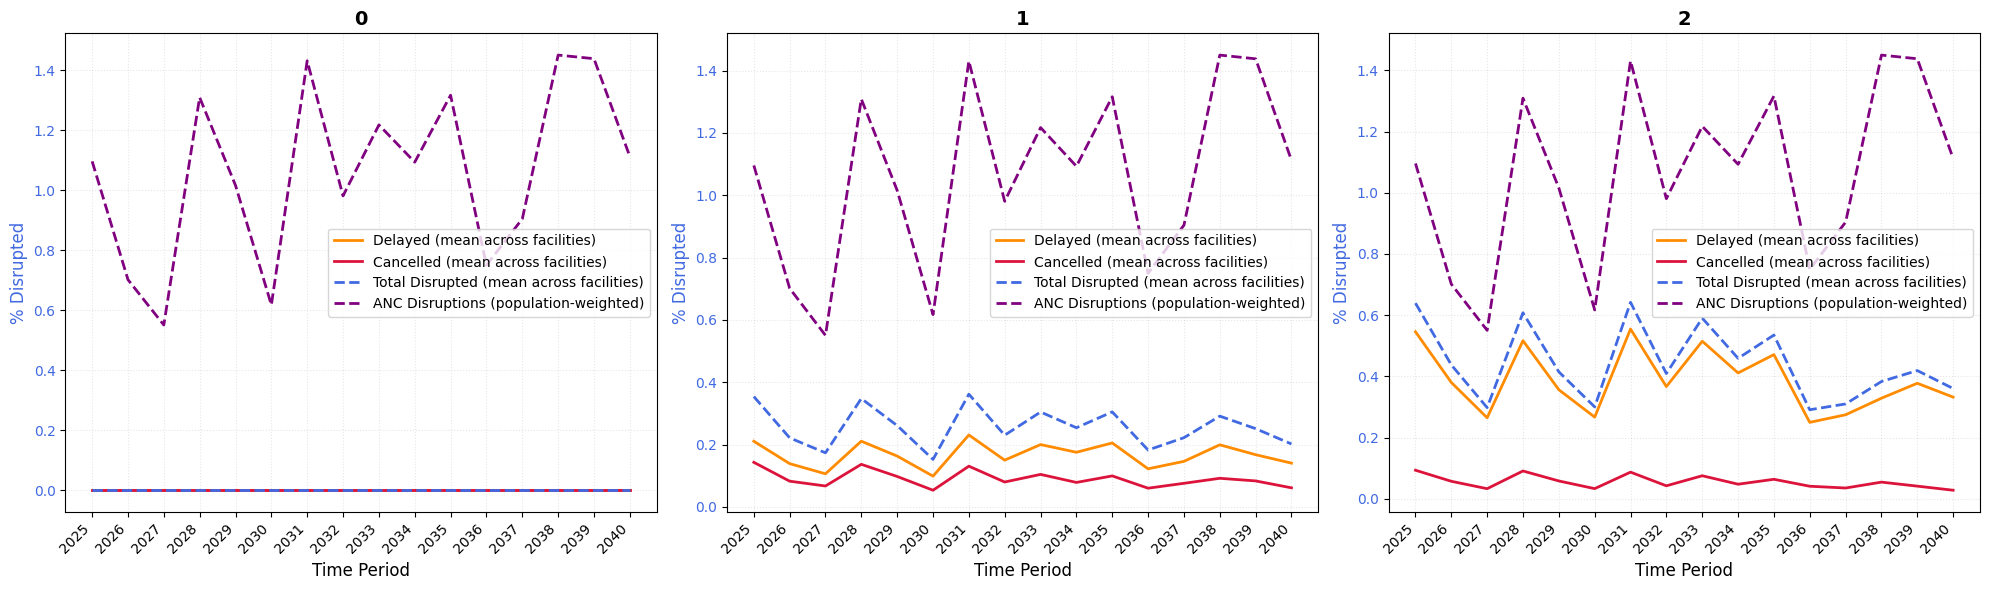

In [69]:
from collections import defaultdict
import re
# Now create the plots with dual y-axes
appointment_delayed_scenarios = {}
appointment_cancelled_scenarios = {}
daly_scenarios = {}

for draw in range(len(scenarios_of_interest)):

    delayed_by_scenario = all_scenarios_appointment_delayed_mean[draw]
    cancelled_by_scenario = all_scenarios_appointment_cancelled_mean[draw]
    daly_by_scenario = all_scenarios_dalys_mean[draw]

    # Now values are Series (by facility), so aggregate across facilities
    delayed_all_years = [delayed_by_scenario[year].mean() if isinstance(delayed_by_scenario[year], pd.Series) else delayed_by_scenario[year] 
                         for year in sorted(delayed_by_scenario.keys())]
    cancelled_all_years = [cancelled_by_scenario[year].mean() if isinstance(cancelled_by_scenario[year], pd.Series) else cancelled_by_scenario[year]
                           for year in sorted(cancelled_by_scenario.keys())]

    appointment_delayed_scenarios[draw] = delayed_all_years
    appointment_cancelled_scenarios[draw] = cancelled_all_years

scenario_names_filtered = list(appointment_delayed_scenarios.keys())

n_scenarios = len(scenario_names_filtered)
n_cols = min(3, n_scenarios)
n_rows = (n_scenarios + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
if n_scenarios == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for i, draw in enumerate(scenarios_of_interest):
    print(f"\n=== Processing draw {draw} ===")
    ax1 = axes[i]

    delayed_data = np.array(appointment_delayed_scenarios[draw], dtype=float) * 100
    cancelled_data = np.array(appointment_cancelled_scenarios[draw], dtype=float) * 100
    total_data = delayed_data + cancelled_data

    # Get the years from your data
    years = sorted(all_scenarios_appointment_delayed_mean[draw].keys())
    start_date = pd.to_datetime([f'{y}-01-01' for y in years])
    
    # === Load ANC disruption data and process ===
    ssp = "ssp245"
    model = "mean"
    service = "ANC"
    
    # **LOAD FACILITY PROPORTIONS FROM SIMULATION OUTPUT**
    facility_proportions = pd.read_csv(
        f'/Users/rem76/Desktop/Climate_Change_Health/facility_proportions_by_district_level.csv'
    )
    print(f"\nFacility proportions shape: {facility_proportions.shape}")
    print(f"Facility proportions head:\n{facility_proportions.head()}")
    print(f"Number of unique facilities in proportions: {facility_proportions['Facility'].nunique()}")
    print(f"Proportion stats:\n{facility_proportions['Proportion'].describe()}")
    
    # Load the facility-level predictions
    facility_df = pd.read_csv(
        f"/Users/rem76/Desktop/Climate_Change_Health/Data/"
        f"weather_predictions_with_X_{ssp}_{model}_{service}.csv"
    )
    
    print(f"\nFacility_df shape before processing: {facility_df.shape}")
    print(f"Facility_df columns: {facility_df.columns.tolist()}")
    
    # Load the disruptions file
    disruptions_df = pd.read_csv(
        "/Users/rem76/PycharmProjects/TLOmodel/resources/climate_change_impacts/"
        f"ResourceFile_Precipitation_Disruptions_{ssp}_mean.csv"
    )
    
    # Rename columns if needed for clarity
    disruptions_df = disruptions_df.rename(columns={
        'Unnamed: 0': 'Index',
    })
    
    # Merge to align facilities
    facility_df = facility_df.merge(
        disruptions_df[['RealFacility_ID', 'year', 'month', 'disruption']],  
        left_on=['Facility_ID', 'Year', 'Month'],
        right_on=['RealFacility_ID', 'year', 'month'],
        how='left'
    )

    # Set Difference_in_Expectation to 0 where disruption value is 0
    facility_df.loc[facility_df['disruption'] == 0, 'Difference_in_Expectation'] = 0
    
    # Drop the merge column if you don't need it
    facility_df = facility_df.drop(columns=['disruption'])
    
    # Define facility level mapping with comprehensive patterns
    facility_levels_types = {
        "level_0": [
            "Health Post",
            "Village Health Committee", 
            "Community Health Station",
            "Village Clinic",
            "Mobile Clinic",
            "Outreach Clinic",
            "Dispensary",
        ],
        "level_1a": [
            "Health Centre",
            "Rural Health Centre",
            "Urban Health Centre",
            "Clinic",
            "Private Clinic",
            "Special Clinic",
            "Antenatal Clinic",
            "Maternity Clinic",
            "Maternity Facility",
            "Medical Centre",
        ],
        "level_1b": [
            "Community Hospital",
            "Rural Hospital", 
            "CHAM Hospital",
            "Rural/Community Hospital",
            "Mission Hospital",
        ],
        "level_2": [
            "District Hospital",
            "District Health Office",
        ],
        "level_3": [
            "Kamuzu Central Hospital",
            "Mzuzu Central Hospital",
            "Zomba Central Hospital",
            "Queen Elizabeth Central Hospital",
            "Central Hospital",
        ],
        "level_4": [
            "Zomba Mental Hospital",
            "Mental Hospital",
            "Psychiatric Hospital",
        ],
    }

    # Create reverse lookup: FType -> Level
    ftype_to_level = {}
    for level, ftypes in facility_levels_types.items():
        for ftype in ftypes:
            ftype_to_level[ftype] = level
    
    # Store unmatched facilities for diagnostics
    unmatched_facilities = defaultdict(int)
    
    def map_facility_to_level(ftype, track_unmatched=True):
        """Map facility type to hierarchical level with improved fuzzy matching."""
        if pd.isna(ftype):
            return None
        
        # Direct match (case-sensitive first for speed)
        if ftype in ftype_to_level:
            return ftype_to_level[ftype]
        
        # Prepare for fuzzy matching
        ftype_lower = ftype.lower().strip()
        ftype_clean = re.sub(r'\s+', ' ', ftype_lower)
        
        # Level 3: Central hospitals
        if any(term in ftype_clean for term in ['central hospital', 'referral hospital']):
            return 'level_3'
        
        # Level 4: Mental/Psychiatric hospitals
        if any(term in ftype_clean for term in ['mental hospital', 'psychiatric']):
            return 'level_4'
        
        # Level 2: District hospitals/offices
        if any(term in ftype_clean for term in ['district hospital', 'district health office']):
            return 'level_2'
        
        # Level 1b: Community/Rural/Mission hospitals
        if 'hospital' in ftype_clean:
            if any(term in ftype_clean for term in ['community', 'rural', 'cham', 'mission']):
                return 'level_1b'
            return 'level_1b'
        
        # Level 1a: Health centres and clinics
        if any(term in ftype_clean for term in ['health centre', 'health center']):
            return 'level_1a'
        
        if 'clinic' in ftype_clean:
            if 'village' in ftype_clean or 'mobile' in ftype_clean or 'outreach' in ftype_clean:
                return 'level_0'
            return 'level_1a'
        
        # Level 0: Dispensaries, health posts, village facilities
        if any(term in ftype_clean for term in [
            'dispensary', 'health post', 'village', 'mobile', 'outreach',
            'community health station'
        ]):
            return 'level_0'
        
        if track_unmatched:
            unmatched_facilities[ftype] += 1
        
        return None
    
    # Add Level column based on Facility_Type
    facility_df['Level'] = facility_df['Facility_Type'].apply(map_facility_to_level)

    # Remove rows with missing District or Level
    facility_df = facility_df.dropna(subset=['District', 'Level'])
    print(f"Facility_df shape after adding Level and dropping NAs: {facility_df.shape}")

    # Get simulation date range
    start_year = min_year
    start_month = 1
    end_year = max_year - 1
    end_month = 12
    
    # Filter to match simulation period
    facility_df = facility_df[
        ((facility_df["Year"] == start_year) & (facility_df["Month"] >= start_month)) |
        ((facility_df["Year"] > start_year) & (facility_df["Year"] < end_year)) |
        ((facility_df["Year"] == end_year) & (facility_df["Month"] <= end_month))
    ]
    print(f"Facility_df shape after date filtering: {facility_df.shape}")
    
    # Check for facility name column
    facility_name_candidates = [col for col in facility_df.columns 
                               if any(x in col.lower() for x in ['facility', 'fname', 'name']) 
                               and col not in ['Facility_ID', 'Facility_Type', 'Level']]
    print(f"\nPossible facility name columns: {facility_name_candidates}")
    
    if facility_name_candidates:
        facility_name_col = facility_name_candidates[0]
        print(f"Using facility name column: {facility_name_col}")
        
        # Check for overlapping facilities
        facilities_in_weather_data = set(facility_df[facility_name_col].unique())
        facilities_in_proportions = set(facility_proportions['Facility'].unique())
        overlap = facilities_in_weather_data.intersection(facilities_in_proportions)
        print(f"\nFacilities in weather data: {len(facilities_in_weather_data)}")
        print(f"Facilities in proportions: {len(facilities_in_proportions)}")
        print(f"Overlapping facilities: {len(overlap)}")
        
        if len(overlap) == 0:
            print("\nWARNING: NO OVERLAPPING FACILITIES! Checking samples...")
            print(f"Sample from weather data: {list(facilities_in_weather_data)[:5]}")
            print(f"Sample from proportions: {list(facilities_in_proportions)[:5]}")
        
        # Merge with facility proportions
        weighted_facility_df = facility_df.merge(
            facility_proportions[['District', 'Level', 'Facility', 'Proportion']],
            left_on=['District', 'Level', facility_name_col],
            right_on=['District', 'Level', 'Facility'],
            how='left'
        )
        
        print(f"\nShape after merge: {weighted_facility_df.shape}")
        print(f"Rows with non-null Proportion: {weighted_facility_df['Proportion'].notna().sum()}")
        print(f"Proportion stats after merge:\n{weighted_facility_df['Proportion'].describe()}")
        
        # Fill missing proportions with equal weight instead of 0
        # This ensures we don't lose all facilities
        num_missing = weighted_facility_df['Proportion'].isna().sum()
        if num_missing > 0:
            print(f"\nWARNING: {num_missing} rows with missing proportions")
            # Use equal weighting for unmatched facilities
            weighted_facility_df['Proportion'] = weighted_facility_df['Proportion'].fillna(1.0 / len(weighted_facility_df))
        
        # Apply weights
        weighted_facility_df['Weighted_No_Weather'] = (
            weighted_facility_df['Predicted_No_Weather_Model'] * weighted_facility_df['Proportion']
        )
        weighted_facility_df['Weighted_Difference'] = (
            weighted_facility_df['Difference_in_Expectation'] * weighted_facility_df['Proportion']
        )
        
        print(f"\nWeighted_No_Weather stats:\n{weighted_facility_df['Weighted_No_Weather'].describe()}")
        print(f"Weighted_Difference stats:\n{weighted_facility_df['Weighted_Difference'].describe()}")
        
        # Aggregate
        grouped = weighted_facility_df.groupby(['Level', 'District', 'Year'], as_index=False).agg({
            'Weighted_No_Weather': 'sum',
            'Weighted_Difference': 'sum'
        })
        
        print(f"\nGrouped shape: {grouped.shape}")
        print(f"Grouped head:\n{grouped.head()}")
        
        # Calculate disruption percentage
        grouped['Disruption_Pct'] = (
            grouped['Weighted_Difference'].abs() / 
            grouped['Weighted_No_Weather'].replace(0, np.nan)  # Avoid division by zero
        ) * 100
        
        label_suffix = "(population-weighted)"
    else:
        print("\nWARNING: No facility name column found, using unweighted aggregation")
        # Fallback
        grouped = facility_df.groupby(['Level', 'District', 'Year'], as_index=False).agg({
            'Predicted_No_Weather_Model': 'sum',
            'Difference_in_Expectation': 'sum'
        })
        
        grouped['Disruption_Pct'] = (
            grouped['Difference_in_Expectation'].abs() / 
            grouped['Predicted_No_Weather_Model'].replace(0, np.nan)
        ) * 100
        
        label_suffix = "(unweighted)"
    
    print(f"\nDisruption_Pct stats:\n{grouped['Disruption_Pct'].describe()}")
    
    # Average by year
    avg_df = grouped.groupby('Year', as_index=False)['Disruption_Pct'].mean()
    avg_df = avg_df.sort_values('Year')
    
    print(f"\nFinal avg_df:\n{avg_df}")
    
    # Extract values for plotting
    anc_disruption_values = avg_df['Disruption_Pct'].values
    
    # Plot
    line1 = ax1.plot(start_date, delayed_data, label="Delayed (mean across facilities)", linewidth=2, color='#FF8C00')
    line2 = ax1.plot(start_date, cancelled_data, label="Cancelled (mean across facilities)", linewidth=2, color='#DC143C')
    line3 = ax1.plot(start_date, total_data, label="Total Disrupted (mean across facilities)", linewidth=2, color='#4169E1', linestyle='--')
    
    line4 = ax1.plot(start_date, anc_disruption_values, label=f"ANC Disruptions {label_suffix}", linewidth=2, color='purple', linestyle='--')

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

    ax1.set_xlabel("Time Period", fontsize=12)
    ax1.set_ylabel("% Disrupted", fontsize=12, color='#4169E1')
    ax1.tick_params(axis='y', labelcolor='#4169E1')
    ax1.set_title(f"{draw}", fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle=':')

    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best', fontsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Add in months

In [70]:
results_folder_baseline = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/baseline_run_with_pop-2026-02-05T113912Z')


# Helper functions
def get_hsi_counts_by_facility_monthly(_df):
    """Get HSI counts by facility_id and month - returns with month as part of index"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    if len(_df) == 0:
        return pd.Series(dtype=int)

    # Create keys like "2010-01_128" (YYYY-MM_facilityID)
    facility_month_totals = {}
    for _, row in _df.iterrows():
        month_key = row['date'].strftime('%Y-%m')
        counts_dict = row['counts']

        for key, value in counts_dict.items():
            if ':' in key:
                facility_id, _ = key.split(':', 1)
                combined_key = f"{month_key}_{facility_id}"
                facility_month_totals[combined_key] = facility_month_totals.get(combined_key, 0) + value

    return pd.Series(facility_month_totals)


def get_num_treatments_by_facility_delayed(_df):
    """Count number of delayed HSI events by facility and month"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="delayed_count")
    
    # Extract month from date
    _df['month'] = _df['date'].dt.strftime('%Y-%m')
    
    # Create combined key: month_facilityID
    _df['month_facility'] = _df['month'] + '_' + _df['Facility_ID'].astype(str)
    
    # Group by month_facility and count
    delayed_by_month_facility = _df.groupby('month_facility').size()
    delayed_by_month_facility.name = 'delayed_count'
    
    return delayed_by_month_facility


def get_num_treatments_by_facility_cancelled(_df):
    """Count number of cancelled HSI events by facility and month"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="cancelled_count")
    
    # Extract month from date
    _df['month'] = _df['date'].dt.strftime('%Y-%m')
    
    # Create combined key: month_facilityID
    _df['month_facility'] = _df['month'] + '_' + _df['Facility_ID'].astype(str)
    
    # Group by month_facility and count
    cancelled_by_month_facility = _df.groupby('month_facility').size()
    cancelled_by_month_facility.name = 'cancelled_count'
    
    return cancelled_by_month_facility


# Storage dictionaries
all_scenarios_appointment_delayed_mean = {}
all_scenarios_appointment_cancelled_mean = {}
all_scenarios_dalys_mean = {}
scenarios_of_interest = range(3)

# Main loop
for draw in range(len(scenarios_of_interest)):
    print(draw)
    all_years_data_delayed_mean = {}
    all_years_data_cancelled_mean = {}
    all_years_dalys_mean = {}
    baseline_hsi_by_month_facility = {}
    
    for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Get baseline HSI by month and facility (format: "YYYY-MM_facilityID")
        hsi_by_month_facility = summarize(extract_results(
            results_folder_baseline,
            module='tlo.methods.healthsystem.summary',
            key='hsi_event_counts_by_facility_monthly',
            custom_generate_series=get_hsi_counts_by_facility_monthly,
            do_scaling=False
        ), only_mean=True, collapse_columns=False)[draw]

        baseline_hsi_by_month_facility[target_year] = hsi_by_month_facility

        if draw in [0]:
            all_years_data_delayed_mean[target_year] = pd.Series([0], name='mean')
            all_years_data_cancelled_mean[target_year] = pd.Series([0], name='mean')
        else:
            # Get delayed counts BY MONTH AND FACILITY
            num_delayed_by_month_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_delayed_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_delayed,
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Get cancelled counts BY MONTH AND FACILITY
            num_cancelled_by_month_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_cancelled_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_cancelled,
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Align and calculate proportions at month-facility level
            baseline_aligned, delayed_aligned = baseline_hsi_by_month_facility[target_year].align(
                num_delayed_by_month_facility, fill_value=0
            )
            delayed_proportions = delayed_aligned / baseline_aligned
            
            baseline_aligned, cancelled_aligned = baseline_hsi_by_month_facility[target_year].align(
                num_cancelled_by_month_facility, fill_value=0
            )
            cancelled_proportions = cancelled_aligned / baseline_aligned
            
            all_years_data_delayed_mean[target_year] = delayed_proportions
            all_years_data_cancelled_mean[target_year] = cancelled_proportions

    all_scenarios_appointment_delayed_mean[draw] = all_years_data_delayed_mean
    all_scenarios_appointment_cancelled_mean[draw] = all_years_data_cancelled_mean
    all_scenarios_dalys_mean[draw] = all_years_dalys_mean

0


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

1


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_13845/917255231.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['month'] = _df['date'].dt.strftime('%Y-%m')
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_13845/917255231.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

2


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_13845/917255231.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['month'] = _df['date'].dt.strftime('%Y-%m')
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_13845/917255231.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/


=== Processing draw 0 ===

=== Processing draw 1 ===

=== Processing draw 2 ===

=== Plotting draw 0 ===

Facility_df shape before processing: (181608, 17)
Facility_df shape after date filtering: (37056, 21)

Final avg_df shape: (192, 4)
Date range: 2025-01-01 00:00:00 to 2040-12-01 00:00:00

=== Plotting draw 1 ===

Facility_df shape before processing: (181608, 17)
Facility_df shape after date filtering: (37056, 21)

Final avg_df shape: (192, 4)
Date range: 2025-01-01 00:00:00 to 2040-12-01 00:00:00

=== Plotting draw 2 ===

Facility_df shape before processing: (181608, 17)
Facility_df shape after date filtering: (37056, 21)

Final avg_df shape: (192, 4)
Date range: 2025-01-01 00:00:00 to 2040-12-01 00:00:00


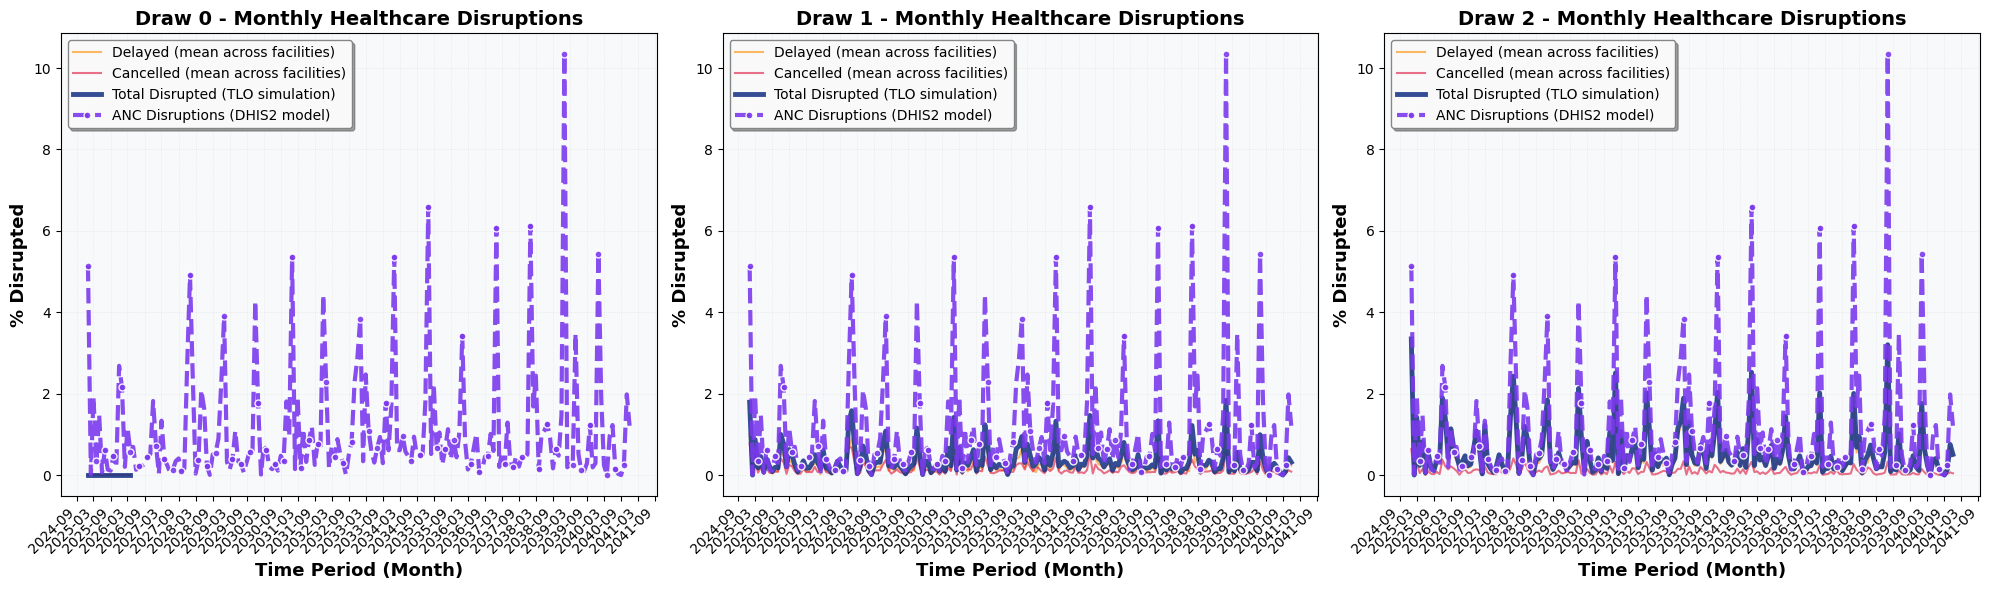

In [74]:
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Create the plots with monthly resolution
appointment_delayed_scenarios = {}
appointment_cancelled_scenarios = {}

for draw in range(len(scenarios_of_interest)):
    print(f"\n=== Processing draw {draw} ===")
    
    delayed_by_scenario = all_scenarios_appointment_delayed_mean[draw]
    cancelled_by_scenario = all_scenarios_appointment_cancelled_mean[draw]
    
    # Aggregate monthly data across facilities for each year
    monthly_delayed_list = []
    monthly_cancelled_list = []
    month_labels = []
    
    for year in sorted(delayed_by_scenario.keys()):
        # Get the Series for this year (indexed by "YYYY-MM_facilityID")
        delayed_series = delayed_by_scenario[year]
        cancelled_series = cancelled_by_scenario[year]
        
        if isinstance(delayed_series, pd.Series) and len(delayed_series) > 0:
            # Extract month from the index (format: "YYYY-MM_facilityID")
            delayed_df = pd.DataFrame({
                'value': delayed_series.values,
                'key': delayed_series.index.astype(str)  # Convert to string
            })
            delayed_df['month'] = delayed_df['key'].str.split('_').str[0]
            
            cancelled_df = pd.DataFrame({
                'value': cancelled_series.values,
                'key': cancelled_series.index.astype(str)  # Convert to string
            })
            cancelled_df['month'] = cancelled_df['key'].str.split('_').str[0]
            
            # Average across facilities for each month
            monthly_delayed = delayed_df.groupby('month')['value'].mean()
            monthly_cancelled = cancelled_df.groupby('month')['value'].mean()
            
            # Store results
            for month in sorted(monthly_delayed.index):
                monthly_delayed_list.append(monthly_delayed.get(month, 0))
                monthly_cancelled_list.append(monthly_cancelled.get(month, 0))
                month_labels.append(month)
        else:
            # Handle draw 0 (baseline)
            for month in range(1, 13):
                month_str = f"{year}-{month:02d}"
                monthly_delayed_list.append(0 if isinstance(delayed_series, pd.Series) else delayed_series)
                monthly_cancelled_list.append(0 if isinstance(cancelled_series, pd.Series) else cancelled_series)
                month_labels.append(month_str)
    
    appointment_delayed_scenarios[draw] = monthly_delayed_list
    appointment_cancelled_scenarios[draw] = monthly_cancelled_list

# Create the plot
n_scenarios = len(scenarios_of_interest)
n_cols = min(3, n_scenarios)
n_rows = (n_scenarios + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
if n_scenarios == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for i, draw in enumerate(scenarios_of_interest):
    print(f"\n=== Plotting draw {draw} ===")
    ax1 = axes[i]
    
    # Convert to percentages
    delayed_data = np.array(appointment_delayed_scenarios[draw], dtype=float) * 100
    cancelled_data = np.array(appointment_cancelled_scenarios[draw], dtype=float) * 100
    total_data = delayed_data + cancelled_data
    
    # Create date index for plotting
    # Recreate month_labels for this draw
    month_labels = []
    for year in sorted(all_scenarios_appointment_delayed_mean[draw].keys()):
        for month in range(1, 13):
            month_labels.append(f"{year}-{month:02d}-01")
    
    date_index = pd.to_datetime(month_labels[:len(delayed_data)])
    
    # === Load and process ANC disruption data at MONTHLY resolution ===
    ssp = "ssp245"
    model = "mean"
    service = "ANC"
    
    # Load facility-level predictions
    facility_df = pd.read_csv(
        f"/Users/rem76/Desktop/Climate_Change_Health/Data/"
        f"weather_predictions_with_X_{ssp}_{model}_{service}.csv"
    )
    
    print(f"\nFacility_df shape before processing: {facility_df.shape}")
    
    # Load disruptions
    disruptions_df = pd.read_csv(
        "/Users/rem76/PycharmProjects/TLOmodel/resources/climate_change_impacts/"
        f"ResourceFile_Precipitation_Disruptions_{ssp}_mean.csv"
    )
    
    disruptions_df = disruptions_df.rename(columns={'Unnamed: 0': 'Index'})
    
    # Merge to align facilities
    facility_df = facility_df.merge(
        disruptions_df[['RealFacility_ID', 'year', 'month', 'disruption']],  
        left_on=['Facility_ID', 'Year', 'Month'],
        right_on=['RealFacility_ID', 'year', 'month'],
        how='left'
    )
    
    facility_df.loc[facility_df['disruption'] == 0, 'Difference_in_Expectation'] = 0
    facility_df = facility_df.drop(columns=['disruption'])
    
    # Define facility level mapping
    facility_levels_types = {
        "level_0": ["Health Post", "Village Health Committee", "Community Health Station",
                    "Village Clinic", "Mobile Clinic", "Outreach Clinic", "Dispensary"],
        "level_1a": ["Health Centre", "Rural Health Centre", "Urban Health Centre", "Clinic",
                     "Private Clinic", "Special Clinic", "Antenatal Clinic", "Maternity Clinic",
                     "Maternity Facility", "Medical Centre"],
        "level_1b": ["Community Hospital", "Rural Hospital", "CHAM Hospital",
                     "Rural/Community Hospital", "Mission Hospital"],
        "level_2": ["District Hospital", "District Health Office"],
        "level_3": ["Kamuzu Central Hospital", "Mzuzu Central Hospital", "Zomba Central Hospital",
                    "Queen Elizabeth Central Hospital", "Central Hospital"],
        "level_4": ["Zomba Mental Hospital", "Mental Hospital", "Psychiatric Hospital"],
    }
    
    ftype_to_level = {}
    for level, ftypes in facility_levels_types.items():
        for ftype in ftypes:
            ftype_to_level[ftype] = level
    
    def map_facility_to_level(ftype):
        if pd.isna(ftype):
            return None
        if ftype in ftype_to_level:
            return ftype_to_level[ftype]
        
        ftype_lower = ftype.lower().strip()
        ftype_clean = re.sub(r'\s+', ' ', ftype_lower)
        
        if any(term in ftype_clean for term in ['central hospital', 'referral hospital']):
            return 'level_3'
        if any(term in ftype_clean for term in ['mental hospital', 'psychiatric']):
            return 'level_4'
        if any(term in ftype_clean for term in ['district hospital', 'district health office']):
            return 'level_2'
        if 'hospital' in ftype_clean:
            if any(term in ftype_clean for term in ['community', 'rural', 'cham', 'mission']):
                return 'level_1b'
            return 'level_1b'
        if any(term in ftype_clean for term in ['health centre', 'health center']):
            return 'level_1a'
        if 'clinic' in ftype_clean:
            if 'village' in ftype_clean or 'mobile' in ftype_clean or 'outreach' in ftype_clean:
                return 'level_0'
            return 'level_1a'
        if any(term in ftype_clean for term in ['dispensary', 'health post', 'village', 'mobile',
                                                  'outreach', 'community health station']):
            return 'level_0'
        return None
    
    facility_df['Level'] = facility_df['Facility_Type'].apply(map_facility_to_level)
    facility_df = facility_df.dropna(subset=['District', 'Level'])
    
    # Filter to simulation period
    start_year = min_year
    start_month = 1
    end_year = max_year - 1
    end_month = 12
    
    facility_df = facility_df[
        ((facility_df["Year"] == start_year) & (facility_df["Month"] >= start_month)) |
        ((facility_df["Year"] > start_year) & (facility_df["Year"] < end_year)) |
        ((facility_df["Year"] == end_year) & (facility_df["Month"] <= end_month))
    ]
    
    print(f"Facility_df shape after date filtering: {facility_df.shape}")
    
    # Simple unweighted aggregation at MONTHLY level
    grouped = facility_df.groupby(['Level', 'District', 'Year', 'Month'], as_index=False).agg({
        'Predicted_No_Weather_Model': 'sum',
        'Difference_in_Expectation': 'sum'
    })
    
    grouped['Disruption_Pct'] = (
        grouped['Difference_in_Expectation'].abs() / 
        grouped['Predicted_No_Weather_Model'].replace(0, np.nan)
    ) * 100
    
    # Average by year AND month
    avg_df = grouped.groupby(['Year', 'Month'], as_index=False)['Disruption_Pct'].mean()
    avg_df = avg_df.sort_values(['Year', 'Month'])
    
    # Create date column for ANC data
    avg_df['Date'] = pd.to_datetime(avg_df['Year'].astype(str) + '-' + 
                                     avg_df['Month'].astype(str).str.zfill(2) + '-01')
    
    print(f"\nFinal avg_df shape: {avg_df.shape}")
    print(f"Date range: {avg_df['Date'].min()} to {avg_df['Date'].max()}")
    
    # Extract values for plotting
    anc_disruption_values = avg_df['Disruption_Pct'].values
    anc_dates = avg_df['Date'].values
    
    # Plot the data with improved visual distinction
    # Use lighter colors and thinner lines for individual components
    line1 = ax1.plot(date_index, delayed_data, 
                     label="Delayed (mean across facilities)", 
                     linewidth=1.5, 
                     color='#FF8C00',
                     alpha=0.6)
    
    line2 = ax1.plot(date_index, cancelled_data, 
                     label="Cancelled (mean across facilities)", 
                     linewidth=1.5, 
                     color='#DC143C',
                     alpha=0.6)
    
    # Make total disrupted line BOLD and distinct
    line3 = ax1.plot(date_index, total_data, 
                     label="Total Disrupted (TLO simulation)", 
                     linewidth=3.5,  # Thicker line
                     color='#1E3A8A',  # Darker blue
                     linestyle='-',  # Solid line
                     alpha=0.9,
                     zorder=5)  # Plot on top
    
    # Make ANC line BOLD with markers for extra distinction
    line4 = ax1.plot(anc_dates, anc_disruption_values, 
                     label="ANC Disruptions (DHIS2 model)", 
                     linewidth=3,  # Thicker line
                     color='#7C3AED',  # Distinct purple
                     linestyle='--',  # Dashed
                     marker='o',  # Add circular markers
                     markevery=3,  # Show marker every 3 points (every 3 months)
                     markersize=5,
                     markerfacecolor='#7C3AED',
                     markeredgecolor='white',
                     markeredgewidth=1,
                     alpha=0.9,
                     zorder=5)  # Plot on top
    
    # Format x-axis for monthly data
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show every 6 months
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax1.set_xlabel("Time Period (Month)", fontsize=13, fontweight='bold')
    ax1.set_ylabel("% Disrupted", fontsize=13, fontweight='bold')
    ax1.set_title(f"Draw {draw} - Monthly Healthcare Disruptions", fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    
    # Improved legend with better positioning and styling
    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, 
               loc='best', 
               fontsize=10,
               framealpha=0.95,
               edgecolor='gray',
               fancybox=True,
               shadow=True)
    
    # Add subtle background color
    ax1.set_facecolor('#F8F9FA')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()